In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
# Use Tensorboard for network visualization & debugging
from tensorflow.keras.callbacks import TensorBoard
import sklearn.metrics
# import regularizer(s)
from tensorflow.keras.regularizers import l1, l2, l1_l2
# import Dropout
from tensorflow.keras.layers import Dropout
# import activation seperately
from tensorflow.keras.layers import Activation

In [3]:
## Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1) LOAD THE DATA

In [4]:
V52_data = pd.read_csv('V52_data_process.csv')
# make Date the index in datetime format
V52_data.index = pd.to_datetime(V52_data['Date'], format='%Y%m%d%H%M')

## -----------------------------------------------------------------

In [5]:
### define a function that will prepare the shifting input sequences for the network
def forecast_sequences_input(input_data, n_lag):
    """
    A function that will split the input time series to sequences for nowcast/forecast problems
    Arguments:
        input_data: Time series of input observations as a list, NumPy array or pandas series
        n_lag: number of previous time steps to use for training, a.k.a. time-lag        
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = input_data.shape[1] 
    df = pd.DataFrame(input_data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg


### define a function that will prepare the shifting output sequences of the network
def forecast_sequences_output(output_data,n_out):
    """
    A function that will split the output time series to sequences for nowcast/forecast problems
    Arguments:
        output_data: Time series of input observations as a list, NumPy array or pandas series
        n_out: forecast horizon (for multi-output forecast)
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = output_data.shape[1] 
    df = pd.DataFrame(output_data)
    cols, names = list(), list()
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names    
    return agg


## ------------------------------------------------------------------

## 2) CREATE AND DATA FRAME  WITH THE VARIABLES TO BE USED IN THE MODEL

In [6]:
# Save input data in a dataframe -> ActPow and date as index

X = V52_data[['ActPow']]
y = V52_data[['ActPow']]

# In this case X and y has the same colum as it is univariate model

### Define length of the input and output intervals within the sequences

In [7]:
n_lag = 6  # number of previous time steps to use for training, a.k.a. time-lag
n_out = 1  # forecast hoizon: number of next time steps we will predict 1 = the next 10-min mean

### Sequence creation

In [8]:
### Split data into train & test 
train_int = int(0.6*len(X))      # 60% of the data length for training
validation_int = int(0.8*len(X)) # 20% more for validation

# training input vector
X_train = X[:train_int]
X_train = forecast_sequences_input(X_train, n_lag)

# training output vector
Y_train = y[:train_int]
Y_train = forecast_sequences_output(Y_train, n_out)

# validation input vector
X_validation = X[train_int:validation_int]
X_validation = forecast_sequences_input(X_validation, n_lag)

# validation output vector
Y_validation = V52_data[['ActPow']][train_int:validation_int]
Y_validation = forecast_sequences_output(Y_validation, n_out)

# test input vector
X_test = V52_data[['ActPow']][validation_int:]
X_test = forecast_sequences_input(X_test, n_lag)

# test output vector
Y_test = V52_data[['ActPow']][validation_int:]
Y_test = forecast_sequences_output(Y_test, n_out)

### Drop NaN Raws
      As now the sequences has beeen created, each row has already the  last values.

In [9]:
# Find when there is a nan in the y-data and remove it from it. Also reºmove the same rows from the X-data which will be one more

Y_train = Y_train.dropna()
train_index = Y_train.index
X_train = X_train.loc[train_index ]

Y_validation = Y_validation.dropna()
validation_index = Y_validation.index
X_validation = X_validation.loc[validation_index]

Y_test = Y_test.dropna()
test_index = Y_test.index
X_test = X_test.loc[test_index]

In [10]:
print("X_train shape:", X_train.shape)
print("X_validation shape:", X_validation.shape)
print("X_test shape:", X_test.shape)

X_train shape: (22010, 6)
X_validation shape: (8169, 6)
X_test shape: (6889, 6)


### Scale the data

In [11]:
from sklearn.preprocessing import MinMaxScaler
### scale the dataset
scalerx = MinMaxScaler(feature_range=(0, 1))
scalery = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scalerx.fit_transform(X_train)
X_validation_scaled = scalerx.transform(X_validation)
X_test_scaled = scalerx.transform(X_test)

Y_train_scaled = scalery.fit_transform(Y_train)
Y_validation_scaled = scalery.transform(Y_validation)
Y_test_scaled = scalery.transform(Y_test)

print('Training input (samples, timesteps):', X_train_scaled.shape)
print('Training output (samples, timesteps):', Y_train.shape)
print('Validation input (samples, timesteps):', X_validation_scaled.shape)
print('Validation output (samples, timesteps):', Y_validation.shape)


Training input (samples, timesteps): (22010, 6)
Training output (samples, timesteps): (22010, 1)
Validation input (samples, timesteps): (8169, 6)
Validation output (samples, timesteps): (8169, 1)


### Pad NaNs for missing periods with a significant number (to be 'masked' for the training later)

In [12]:
pad_value = 999

X_train_scaled[np.isnan(X_train_scaled)] = pad_value
X_validation_scaled[np.isnan(X_validation_scaled)] = pad_value
X_test_scaled[np.isnan(X_test_scaled)] = pad_value

In [13]:
X_train_scaled.shape

(22010, 6)

In [14]:
Y_train_scaled.shape

(22010, 1)

## 3) LSTM architecture

In [15]:
from tensorflow.keras.layers import LSTM, Masking

# for multiple model creation - clear  the previous DAG
K.clear_session() 

### Input reshape for LSTM problem  [samples, timesteps, features]
no_features = 1 # Avg and Std of wind speed

train_X = X_train_scaled.reshape((X_train_scaled.shape[0], n_lag, no_features)).astype('float32')
train_Y = Y_train.values.astype('float32')

validation_X = X_validation_scaled.reshape((X_validation_scaled.shape[0], n_lag, no_features)).astype('float32')
validation_Y = Y_validation.values.astype('float32')

test_X = X_test_scaled.reshape((X_test_scaled.shape[0], n_lag, no_features)).astype('float32')
test_Y = Y_test.values.astype('float32')

In [16]:
### create model
model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))


# First LSTM layer
model.add(LSTM(50, 
               return_sequences=True,  # important to add it to ensure the following LSTM layers will have the same input shape
               input_shape=(train_X.shape[1], train_X.shape[2]),                
               kernel_initializer='random_uniform',
               bias_initializer='zeros'))
               
# then we add the activation
model.add(Activation('tanh'))

# Second LSTM layer
model.add(LSTM(10, activation='tanh'))

# Output Layer
model.add(Dense(1, activation='tanh'))
model.summary()

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# fit the model and store the graphs and performance to be used in TensorBoard (optional)
now = datetime.datetime.now().strftime("%Y%m%d%H%M")

tbGraph = TensorBoard(log_dir=f'.\Graph\{now}',
                      histogram_freq=64*2, write_graph=True, write_images=True)

history = model.fit(train_X, train_Y, 
          epochs=30,
          batch_size=1000,
          validation_data=(validation_X, validation_Y),
          callbacks=[tbGraph])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, None, 50)          10400     
                                                                 
 activation (Activation)     (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                2440      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 12851 (50.20 KB)
Trainable params: 12851 (50.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
23/23 [==

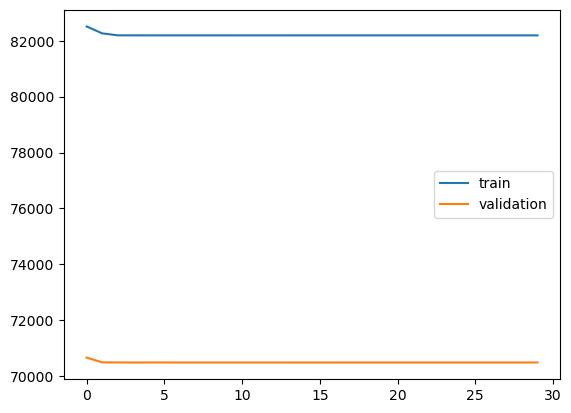

In [17]:
# plot the lost
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.legend()

In [18]:
# Fit a new scaler on the single feature you're predicting
scaler_single = MinMaxScaler()
scaler_single.fit(train_Y.reshape(-1, 1))  # Reshape to 2D array

MinMaxScaler()

In [19]:
# Make predictions and plot them against the actual values
predictions = model.predict(test_X)

#predictions = scalery.inverse_transform(predictions)
predictions = scaler_single.inverse_transform(predictions)

test_Y = scalery.inverse_transform(test_Y)


216/216 [==============================] - 4s 3ms/step


In [20]:

test_Y

array([[ 41230.62],
       [ 34569.49],
       [ 42170.08],
       ...,
       [544621.7 ],
       [471753.3 ],
       [436433.9 ]], dtype=float32)

In [21]:
from scipy import stats
mode = stats.mode(predictions)
print(mode.mode[0])
predictions[predictions == mode.mode[0]] = np.nan
predictions

861.4116821289062


array([[ 45.869995],
       [191.23862 ],
       [461.9634  ],
       ...,
       [861.41113 ],
       [861.41125 ],
       [861.4114  ]], dtype=float32)

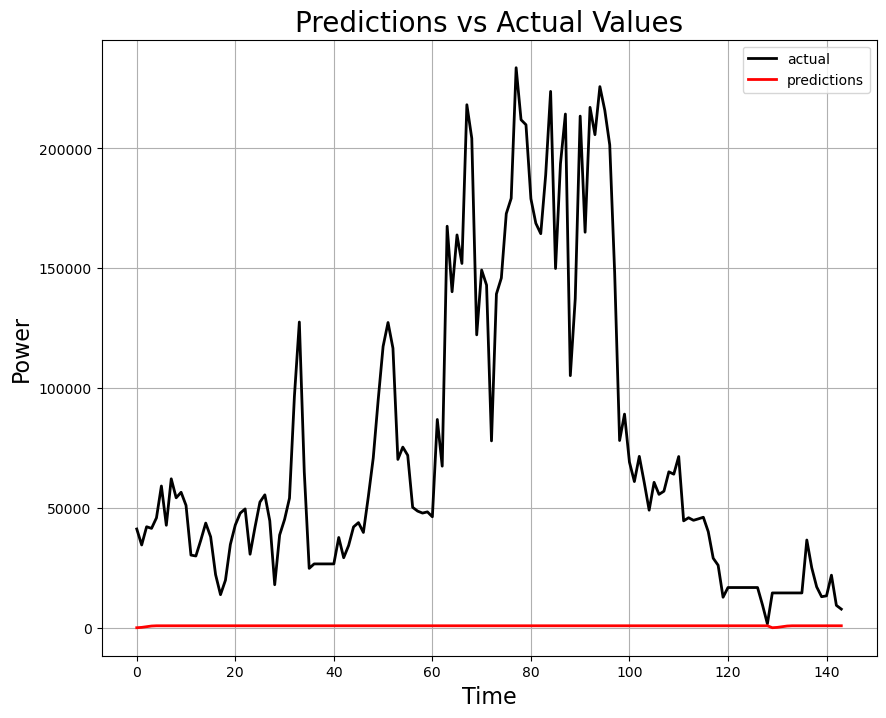

In [22]:

# plot the predictions
plt.figure(figsize=(10,8))

plt.plot(test_Y[:144,-1], 'k', label='actual', linewidth=2)
plt.plot(predictions[:144],'-r', label='predictions', linewidth=2)
plt.grid(True)

plt.title('Predictions vs Actual Values', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Power', fontsize=16)

plt.legend()